In [84]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
from pathlib import Path
import matplotlib.pyplot as plt
from torch import tensor

# Load data

In [86]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
path = datasets.download_data(MNIST_URL, ext='.gz'); path

WindowsPath('C:/Users/s.lagousis.POBUCA/.fastai/data/mnist.pkl.gz')

In [87]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    
# without gzip
# path = Path('C:/Users/s.lagousis.POBUCA/.fastai/data/mnist.pkl')
# with open(path, 'rb') as f:
#     ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [95]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         ...,
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [18]:
import operator
def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [21]:
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [22]:
mpl.rcParams['image.cmap'] = 'gray'
img = x_train[0]
img.view(28,28).type()

'torch.FloatTensor'

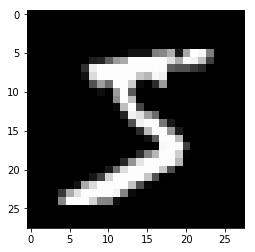

In [23]:
plt.imshow(img.view((28,28)));

In [24]:
weights = torch.randn(784,10)
bias = torch.zeros(10)

# Matrix multiplication

In [25]:
m1 = x_valid[:5]
m2 = weights
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [32]:
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [37]:
%time t1=matmul(m1, m2)

Wall time: 988 ms


In [36]:
t1.shape

torch.Size([5, 10])

In [40]:
def matmul2(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [55]:
%time t2=matmul2(m1, m2)

Wall time: 4.92 ms


In [42]:
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [44]:
test_near(t1,matmul2(m1, m2))

In [53]:
def matmul3(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

In [54]:
%time t3=matmul3(m1, m2)

Wall time: 2.05 ms


In [69]:
z = m1[0]
z[:, None].shape

torch.Size([784, 1])

In [71]:
m1[0,:,None].shape

torch.Size([784, 1])

In [60]:
m1[0].unsqueeze(-1).shape

torch.Size([784, 1])

In [62]:
m1[0].unsqueeze(-1).expand_as(m2).shape

torch.Size([784, 10])

In [72]:
test_near(t3,matmul2(m1, m2))

In [73]:
def matmul4(a,b): torch.einsum('ik,kj->ij', a, b)

In [75]:
%time t4=matmul4(m1, m2)

Wall time: 1.02 ms


In [82]:
%time t5=m1.matmul(m2)

Wall time: 0 ns


In [79]:
test_near(t5,matmul2(m1, m2))

In [83]:
%time t6=m1@m2

Wall time: 881 µs


# Fully connected

In [89]:
# m = mean, s = standard deviation
def normalize(x, m, s): return (x-m)/s

In [90]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(0.13044983, 0.3072898)

In [91]:
x_train = normalize(x_train, train_mean, train_std)
# NB: Use training, not validation mean for validation set
x_valid = normalize(x_valid, train_mean, train_std)

In [92]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(-3.1638146e-07, 0.99999934)

In [93]:
def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

In [96]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [97]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

In [124]:
# num hidden
nh = 50
# 1st layer is 784 (=m) x nh, second is nh x 1
# simplified kaiming init / he init
w1 = torch.randn(m,nh) /math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1) /math.sqrt(nh)
b2 = torch.zeros(1)

In [125]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [126]:
w1.mean(), w1.std(), math.sqrt(m), 1/math.sqrt(m)

(tensor(-0.0004), tensor(0.0357), 28.0, 0.03571428571428571)

In [127]:
# This should be ~ (0,1) (mean,std)...
x_valid.mean(),x_valid.std()

(tensor(-0.0059), tensor(0.9924))

In [128]:
def lin(x, w, b): return x@w + b

In [129]:
t = lin(x_valid, w1, b1)

In [130]:
#...so should this, because we used kaiming init, which is designed to do this
t.mean(),t.std()

(tensor(-0.0537), tensor(1.0577))

In [131]:
def relu(x): return x.clamp_min(0.)

In [132]:
t = relu(lin(x_valid, w1, b1))
t.mean(),t.std()
#ReLU messes with mean and variance

(tensor(0.3939), tensor(0.5882))

In [133]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2/m)

In [134]:
w1.mean(),w1.std()

(tensor(0.0001), tensor(0.0506))

In [135]:
t = relu(lin(x_valid, w1, b1))
t.mean(),t.std()

(tensor(0.5697), tensor(0.8736))

In [136]:
from torch.nn import init

In [137]:
w1 = torch.zeros(m,nh)
init.kaiming_normal_(w1, mode='fan_out')
t = relu(lin(x_valid, w1, b1))

In [138]:
w1.mean(),w1.std()

(tensor(-0.0002), tensor(0.0506))

In [139]:
# what if...?
def relu(x): return x.clamp_min(0.) - 0.5

In [140]:
# kaiming init / he init for relu
w1 = torch.randn(m,nh)*math.sqrt(2./m )
t1 = relu(lin(x_valid, w1, b1))
t1.mean(),t1.std()

(tensor(0.1512), tensor(0.8917))

In [141]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [142]:
%timeit -n 10 _=model(x_valid)

16.2 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [143]:
assert model(x_valid).shape==torch.Size([x_valid.shape[0],1])

In [145]:
model(x_valid).shape, torch.Size([x_valid.shape[0],1])

(torch.Size([10000, 1]), torch.Size([10000, 1]))

# Loss function: MSE

In [146]:
model(x_valid).shape

torch.Size([10000, 1])

We need squeeze() to get rid of that trailing (,1), in order to use mse. (Of course, mse is not a suitable loss function for multi-class classification; we'll use a better loss function soon. We'll use mse for now to keep things simple.)

In [147]:
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [154]:
y_train,y_valid = y_train.float(),y_valid.float()

In [155]:
preds = model(x_train)
preds.shape

torch.Size([50000, 1])

In [156]:
mse(preds, y_train)

tensor(29.1624)